In [155]:
# load data
import pandas as pd
df = pd.read_csv("./Data/SortedPOIs.csv")
TOTAL = len(df)+1
COL = df.columns
print(TOTAL) # 1157569
orders = df.iloc[:,2]
#print(orders)
dfh = pd.read_csv("./Data/hilbert.csv")
#print(len(dfh))
df.iloc[:,3]=dfh
#print(df)

1157571


In [156]:
df = df.sort_values(['hilbert'])
# print(df)
df = df.reset_index(drop=True)
df.iloc[:,2] = orders
# print(df)

import numpy as np
print(np.any(np.isnan(df))) # should be false
print(np.all(np.isfinite(df))) # should be true

True
False


In [158]:
# http://scikit-learn.org/stable/developers/performance.html
from sklearn import linear_model
import ipdb

stages = [1,10,100,1000]
index = []
data = []

start_time=time.time()

for i in range(len(stages)):
    temp = []
    for j in range(stages[i]):
        df_ = pd.DataFrame(columns=COL)
        temp.append(df_)
    data.append(temp)
    
data[0][0] = df
nodatacount = 0

for i in range(len(stages)):
    temp = []
    print("======stage:"+str(i)+"======")
    
    for j in range(stages[i]):
        print("model:"+str(j))
        if len(data[i][j]) == 0:
            nodatacount += 1
            lr = index[0][0]
        else: 
            lr = linear_model.LinearRegression()
            #train_x = data[i][j].iloc[:,0:2]
            train_x = data[i][j].iloc[:,3].reshape(-1,1)
            train_y = data[i][j].iloc[:,2]
            lr.fit(train_x,train_y)
        temp.append(lr)
        # allocate data
        if i < len(stages)-1:
            predicted = lr.predict(train_x)
            for pi in range(len(predicted)): # do not change the prediction
                #print(item)
                if predicted[pi] < 0:
                    predicted[pi] = 0
                if predicted[pi] >= TOTAL:
                    predicted[pi] = TOTAL-1   
            ModelID = ((predicted/TOTAL)*stages[i+1]).astype(int)
            data[i][j].iloc[:,-1]=ModelID
            for k in range(stages[i+1]):
                data[i+1][k] = data[i+1][k].append(data[i][j].loc[data[i][j]['prediction'] == k])
#             too slow!
#             for k in range(len(ModelID)):
#                 data[i+1][ModelID[k]].loc[data[i+1][ModelID[k]].size/3]=data[i][j].iloc[k,:]
#                 if k % 1000 == 0:
#                     print(k)
    index.append(temp)

elapsed_time = time.time() - start_time
print(elapsed_time)
print(nodatacount)

======stage:0======
model:0


D:\anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


======stage:1======
model:0
model:1
model:2
model:3
model:4
model:5
model:6
model:7
model:8
model:9
======stage:2======
model:0
model:1
model:2
model:3
model:4
model:5
model:6
model:7
model:8
model:9
model:10
model:11
model:12
model:13
model:14
model:15
model:16
model:17
model:18
model:19
model:20
model:21
model:22
model:23
model:24
model:25
model:26
model:27
model:28
model:29
model:30
model:31
model:32
model:33
model:34
model:35
model:36
model:37
model:38
model:39
model:40
model:41
model:42
model:43
model:44
model:45
model:46
model:47
model:48
model:49
model:50
model:51
model:52
model:53
model:54
model:55
model:56
model:57
model:58
model:59
model:60
model:61
model:62
model:63
model:64
model:65
model:66
model:67
model:68
model:69
model:70
model:71
model:72
model:73
model:74
model:75
model:76
model:77
model:78
model:79
model:80
model:81
model:82
model:83
model:84
model:85
model:86
model:87
model:88
model:89
model:90
model:91
model:92
model:93
model:94
model:95
model:96
model:97
model:98

In [ ]:
# model persistent
from sklearn.externals import joblib

for i in range(len(index)):
    for j in range(len(index[i])):
        joblib.dump(index[i][j], 'index_'+str(i)+'_'+str(j)+'.pkl')

In [159]:
import numpy as np
# use the generated stage index for prediction
def predict_with_stage_model(model, data):
    totalSize = len(data)+1
    predicted_y = []
    tempy = 0
    for i in range(len(data)):
        modelIndex = 0
        for m in range(len(model)):
#             tempy = model[m][modelIndex].predict(data.iloc[i,:].reshape(1,-1))
            tempy = model[m][modelIndex].predict(data.iloc[i,])
            if tempy < 0:
                tempy = 0
            if tempy >= totalSize:
                tempy = totalSize-1
            if m < len(model)-1:
                modelIndex = int((tempy/totalSize)*len(model[m+1]))
                
        predicted_y.append(tempy)
        
    return predicted_y

82.65196633338928


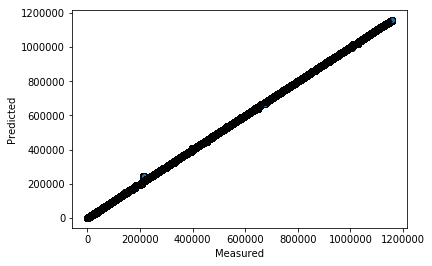

In [148]:
import matplotlib.pyplot as plt
import time

# train_x=df.iloc[:,0:2]
train_x=df.iloc[:,3]
train_y=df.iloc[:,2]
# print(df.iloc[1:3,3])
# print(train_x.iloc[1:3,])

start_time=time.time()
predicted_y = predict_with_stage_model(index, train_x)
elapsed_time = time.time() - start_time
print(elapsed_time)

fig, ax = plt.subplots()
ax.scatter(train_y, predicted_y, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [164]:
# estimate the result
from sklearn.metrics import explained_variance_score
train_y=df.iloc[:,2]
print(len(train_y))
print(len(predicted_y))

# 1- Var(Ytrue - Ypred)/Var(Ytrue)  best: 1  the lower the worse
result = explained_variance_score(train_y, predicted_y)
print(result)

1157570
1157570
0.999980543978


In [165]:
# calculate scan item amount
index = 0
scan = 0
totalscan = 0
for i in range(len(df)):
    index = predicted_y[i]
    scan = abs(index-i) # distance to exact
    totalscan += scan

print(totalscan/len(df))


[ 852.40549364]


In [ ]:
# space filling curve range query
# 用 C++ 改写